In [1]:
import numpy as np
import scipy.io as scio
# import scipy.sparse as sp
# import hdf5storage # get code on https://pypi.python.org/pypi/hdf5storage/0.1.3
# import networkx as nx

import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 写入mat
def WriteMatlab(data_np, VarName, FileName):
    matcontent = {}
    matcontent[VarName] = data_np
    hdf5storage.write(matcontent, filename=FileName, matlab_compatible=True)

In [4]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_10_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'],dtype=int)
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_10_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'],dtype=int)
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size doesn\'t match!"

assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"

if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [5]:
# 参数设置

# 0. 公共参数
Monte_Carlo_loop = 10     # 蒙特卡洛模拟次数
time_steps = 50          # 总时间步数
N = network_scale_1[0]    # 网络节点数
w_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    # S-I断边概率

# 1. SIS参数
bata = 0.2    # 感染概率
mu = 0.4      # 恢复概率

# 2. UAU参数
lamda = 0.3    # 传播率
delta = 0.6    # 遗忘率

# 4. 其他参数
aplha = 0.4      # 信息上传率
iter_ = 0

infective_count_average_total = np.zeros([len(w_list), time_steps])
awareness_count_average_total = np.zeros([len(w_list), time_steps])

In [6]:
for w in w_list:
    
    time_start_w = time.time()
    
    random.seed(256)
    np.random.seed(256)

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)                # 记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)             # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])


    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])



    time_start = time.time()

    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        network_physical_t = np.zeros([time_steps, N, N],dtype=int)    # 每一步接触网络的快照
        network_physical_t[0,:,:] = network_physical[:, :]             # 每一步初始时刻接触网络为原始网络


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    a_1 = 1 - (1 - lamda) ** Num_neighbor_listener    # 最终计算的传播率
                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a_1:
                        Nodes_UAU[loop, t+1, i] = 1
                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘
                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉 


            # ----------更改连边----------
            for i in range(N):
                if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                    
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                    susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 0))[0]                 # 易感节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
                    # neighbor_susceptible = np.intersect1d(susceptible_nodes, neighbor_total)        # 取交集-易感邻居
                    neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 邻居里去除感染邻居-易感邻居

                    destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

                    for infectNeighbor in neighbor_infective:
                        # 如果断边成功，则在当前时刻更改连接
                        if np.random.rand(1) <= w:
                            network_physical_t[t,i,infectNeighbor] = 0
                            network_physical_t[t,infectNeighbor,i] = 0

                            destination = random.choice(destinations)
                            destinations.remove(destination)

                            network_physical_t[t,i,destination] = 1
                            network_physical_t[t,destination,i] = 1

            # ----------SIS演化----------
            for i in range(N):

            # # 0代表易感(S)，如果节点是US，则不做改变，正常感染
            # if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 0)):

                if Nodes_SIS[loop, t, i] == 0:

                    neighbor_total = np.where((network_physical_t[t, i, :] == 1))[0]          # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]               # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)      # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                          # 统计数量

                    # -----SIS感染过程1-----
                    # SIS感染率
                    v_1 = 1 - (1 - bata) ** Num_neighbor_infective
                    p = np.random.rand(1)
                    if p <= v_1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

#                 # 0代表易感(S)，如果节点是AS，需要依概率更改连边
#                 elif ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

#                     neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
#                     infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
#                     susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 0))[0]                 # 易感节点

#                     neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
#                     # neighbor_susceptible = np.intersect1d(susceptible_nodes, neighbor_total)        # 取交集-易感邻居
#                     neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 邻居里去除感染邻居-易感邻居

#                     destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

#                     for infectNeighbor in neighbor_infective:
#                         # 如果断边成功，则在当前时刻更改连接
#                         if np.random.rand(1) <= w:
#                             network_physical_t[t,i,infectNeighbor] = 0
#                             network_physical_t[t,infectNeighbor,i] = 0

#                             destination = random.choice(destinations)
#                             destinations.remove(destination)

#                             network_physical_t[t,i,destination] = 1
#                             network_physical_t[t,destination,i] = 1

#                     # 先重连再感染
#                     neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
#                     # infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
#                     neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居       
#                     Num_neighbor_infective = len(neighbor_infective)                              # 统计

#                     # -----SIS感染过程2-----
#                     v_2 = 1 - (1 - bata) ** Num_neighbor_infective     # 最终计算的感染率
#                     p = np.random.rand(1)
#                     if p <= v_2:
#                         Nodes_SIS[loop, t+1, i] = 1

#                         # 感染节点信息上传(知晓)
#                         p = np.random.rand(1)
#                         if  p <= aplha:
#                             Nodes_UAU[loop, t+1, i] = 1
#                         else:
#                             Nodes_UAU[loop, t+1, i] = 0
#                     else:
#                         Nodes_SIS[loop, t+1, i] = 0

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")

            # 将当前时间的接触网络复制到下一时刻
            network_physical_t[t+1,:,:] = network_physical_t[t,:,:]

        # 保存本次蒙特卡洛循环产生的接触网络数据
        # addr_mat = '../results/loop/'+'loop_'+str(loop)+'.mat'
        # # addr_csv = '../results/loop/'+'loop_'+str(loop)+'.csv'
        # name = 'loop_'+str(loop)
        # scio.savemat(addr, {name: network_physical_t})
        # # np.savetxt(addr_csv, network_physical_t, fmt = '%d', delimiter = ',')

        print("    loop {} - time has passed: {} ".format(loop, time.time()-time_start))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    awareness_count_average = np.mean(awareness_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"

    infective_count_average_total[iter_, :] = infective_count_average/N
    awareness_count_average_total[iter_, :] = awareness_count_average/N
    iter_ += 1

    print("w = {} - time has passed: {} ".format(w, time.time()-time_start))

    loop 0 - time has passed: 10.864027738571167 
    loop 1 - time has passed: 21.809831142425537 
    loop 2 - time has passed: 32.29940629005432 
    loop 3 - time has passed: 42.73321986198425 
    loop 4 - time has passed: 53.861817598342896 
    loop 5 - time has passed: 66.04067873954773 
    loop 6 - time has passed: 77.7537772655487 
    loop 7 - time has passed: 89.27345895767212 
    loop 8 - time has passed: 100.073246717453 
    loop 9 - time has passed: 110.66590642929077 
w = 0 - time has passed: 110.66590642929077 
    loop 0 - time has passed: 11.223489761352539 
    loop 1 - time has passed: 22.249196767807007 
    loop 2 - time has passed: 33.533111572265625 
    loop 3 - time has passed: 44.94732618331909 
    loop 4 - time has passed: 55.75134754180908 
    loop 5 - time has passed: 66.65349292755127 
    loop 6 - time has passed: 78.16578459739685 
    loop 7 - time has passed: 89.06564998626709 
    loop 8 - time has passed: 100.11540508270264 
    loop 9 - time 

In [7]:
# plt.plot(infective_count_average/N, color='blue', label='SIS')
# plt.plot(awareness_count_average/N, color='green', label='UAU')

In [8]:
addr = '../results/'
name1 = 'w_infective'
name2 = 'w_awareness'
scio.savemat(addr+name1+'.mat', {name1: infective_count_average_total})
scio.savemat(addr+name2+'.mat', {name2: awareness_count_average_total})

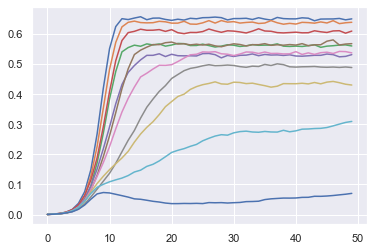

In [9]:
for w_ in range(len(w_list)):
    plt.plot(infective_count_average_total[w_,:], label=str(w_list[w_]))